In [1]:
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, trainers, processors

# Define the alphabet for protein sequences
protein_alphabet = "ACDEFGHIKLMNPQRSTVWY"

# Create a tokenizer with a BPE model
tokenizer = Tokenizer(models.BPE())

# Define a pre-tokenizer that splits on each character
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

# Define a decoder
tokenizer.decoder = decoders.ByteLevel()

# Define a trainer with the protein alphabet
trainer = trainers.BpeTrainer(
    vocab_size=len(protein_alphabet) + 3,  # +3 for <pad>, <eos>, and <s>
    special_tokens=["<pad>", "<mask>", "<eos>", "<s>"],
    initial_alphabet=list(protein_alphabet)
)

# Train the tokenizer on a list of protein sequences
protein_sequences = ["ACDEFGHIKLMNPQRSTVWY", "ACDEFGHIKLMNPQRSTVWY", "ACDEFGHIKLMNPQRSTVWY"]
tokenizer.train_from_iterator(protein_sequences, trainer=trainer)

# Add post-processing to handle special tokens
tokenizer.post_processor = processors.TemplateProcessing(
    single="<s> $A <eos>",
    special_tokens=[
        ("<s>", tokenizer.token_to_id("<s>")),
        ("<eos>", tokenizer.token_to_id("<eos>")),
    ],
)

# Save the tokenizer
tokenizer.save("protein_tokenizer.json")

# Example usage
encoded = tokenizer.encode("ACDEFGHIKLMNPQRSTVWY")
print(encoded.tokens)
vocab = tokenizer.get_vocab()
print("Vocabulary:", vocab)
print("Vocabulary size:", len(vocab))




['<s>', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', '<eos>']
Vocabulary: {'E': 7, '<eos>': 2, 'T': 20, 'K': 12, 'M': 14, '<mask>': 1, '<pad>': 0, 'G': 9, 'I': 11, 'N': 15, 'S': 19, 'V': 21, '<s>': 3, 'R': 18, 'A': 4, 'Y': 23, 'D': 6, 'F': 8, 'H': 10, 'P': 16, 'W': 22, 'Q': 17, 'L': 13, 'C': 5}
Vocabulary size: 24


                               ID  \
0  tr|A0A5P8N3Y8|A0A5P8N3Y8_9POAL   
1  tr|A0A5P8U3Q8|A0A5P8U3Q8_9ROSI   
2  tr|A0A5Q0EJT5|A0A5Q0EJT5_9GAMM   
3  tr|A0A5Q4E8P1|A0A5Q4E8P1_9CYAN   
4  tr|A0A5Q4EAI2|A0A5Q4EAI2_9CYAN   

                                            Sequence  
0  MAPTVMASSATSVAPFQGLKSTASLPVARRSTNGFGNVRTGGRIRC...  
1  MASSILSSAAVASVNSASPAQASMVAPFTGLKSSAGFPITRKNNVD...  
2  MSSFEVGDYQTAQTLETFGFLPKLTQDEVYDQIDYLIAQGWTPAIE...  
3  MWVTTALLAFALRYLMSRWATAALWSGPTLVTTQESEVLAQIEQFL...  
4  MAIRTPAVSPPQQWSSASAVATAQGQGQVLVESGVSLAVGAVVQAD...  
Number of sequences: 3168


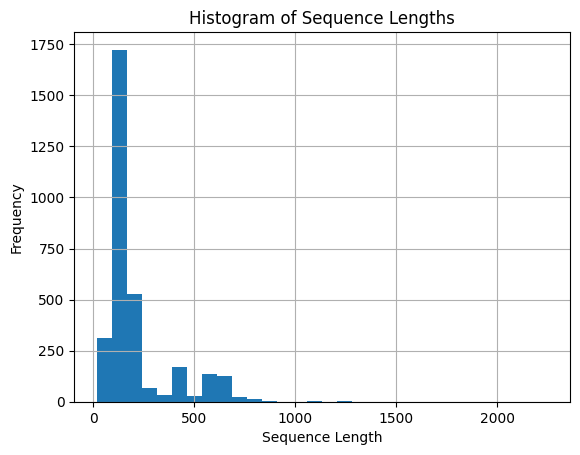

Train dataset size: 2088
Validation dataset size: 261
Test dataset size: 261


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from Bio import SeqIO
import matplotlib.pyplot as plt

BATCH_SIZE = 128

seq_length = 300

# Read a fasta file into a dataframe
def read_fasta_to_df(fasta_file):
    sequences = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences.append({"ID": record.id, "Sequence": str(record.seq)})
    return pd.DataFrame(sequences)



# Example usage
fasta_file = "project/data/clustered90_seq_rep_seq.fasta"
df = read_fasta_to_df(fasta_file)
print(df.head())

print("Number of sequences:", len(df))
# Make a histogram of the sequence lengths
df['Sequence Length'] = df['Sequence'].str.len()
df['Sequence Length'].hist(bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.show()


# Delete entries where df['Sequence'] is longer than max seq length
df = df[df['Sequence'].str.len() <= seq_length-1]

# Tokenize the sequences
df['Tokenized Sequence'] = df['Sequence'].apply(lambda x: tokenizer.encode(x).tokens)

# Split the data into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert tokenized sequences to numerical IDs
def tokenize_sequence(sequence):
    return [tokenizer.token_to_id(token) for token in sequence]

train_sequences = train_df['Tokenized Sequence'].apply(tokenize_sequence).tolist()
val_sequences = val_df['Tokenized Sequence'].apply(tokenize_sequence).tolist()
test_sequences = test_df['Tokenized Sequence'].apply(tokenize_sequence).tolist()

# Convert to PyTorch tensors
train_tensors = [torch.tensor(seq, dtype=torch.long) for seq in train_sequences]
val_tensors = [torch.tensor(seq, dtype=torch.long) for seq in val_sequences]
test_tensors = [torch.tensor(seq, dtype=torch.long) for seq in test_sequences]

# Apply padding to the sequences till length 600
train_tensors = torch.nn.utils.rnn.pad_sequence(train_tensors, batch_first=True, padding_value=tokenizer.token_to_id("<pad>"))
val_tensors = torch.nn.utils.rnn.pad_sequence(val_tensors, batch_first=True, padding_value=tokenizer.token_to_id("<pad>"))
test_tensors = torch.nn.utils.rnn.pad_sequence(test_tensors, batch_first=True, padding_value=tokenizer.token_to_id("<pad>"))

# Ensure all sequences are of length 600
train_tensors = torch.nn.functional.pad(train_tensors, (0, seq_length - train_tensors.size(1)), value=tokenizer.token_to_id("<pad>"))
val_tensors = torch.nn.functional.pad(val_tensors, (0, seq_length - val_tensors.size(1)), value=tokenizer.token_to_id("<pad>"))
test_tensors = torch.nn.functional.pad(test_tensors, (0, seq_length - test_tensors.size(1)), value=tokenizer.token_to_id("<pad>"))

# Create datasets
train_dataset = TensorDataset(train_tensors)
val_dataset = TensorDataset(val_tensors)
test_dataset = TensorDataset(test_tensors)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))



In [11]:
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class TransformerVAE(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, latent_dim, dropout=0):
        super(TransformerVAE, self).__init__()
        self.embedding = nn.Embedding(input_dim, model_dim)
        self.pos_encoder = nn.Embedding(seq_length, model_dim)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.fc_mu = nn.Linear(model_dim, latent_dim)
        self.fc_logvar = nn.Linear(model_dim, latent_dim)
        
        self.fc_latent = nn.Linear(latent_dim, model_dim)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        self.fc_out = nn.Sequential(
            nn.Linear(model_dim, output_dim*2),
            nn.ReLU(),
            nn.Linear(output_dim*2, output_dim),

            )
        self.dropout = nn.Dropout(dropout)

    def encode(self, src):
        src_seq_length = src.size(1)
        src_pos = torch.arange(0, src_seq_length, device=src.device).unsqueeze(0)
        
        src = self.embedding(src) + self.pos_encoder(src_pos)
        src = self.dropout(src)
        
        memory = self.encoder(src)
        memory = memory.mean(dim=1)
        
        mu = self.fc_mu(memory)
        logvar = self.fc_logvar(memory)
        
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, tgt):
        tgt_seq_length = tgt.size(1)
        tgt_pos = torch.arange(0, tgt_seq_length, device=tgt.device).unsqueeze(0)
        
        tgt = self.embedding(tgt) + self.pos_encoder(tgt_pos)
        tgt = self.dropout(tgt)
        
        z = self.fc_latent(z).unsqueeze(1).repeat(1, tgt_seq_length, 1)
        
        output = self.decoder(tgt, z)
        output = output[:, -1:, :]
        #output = output.mean(dim=1)
        #print(output.shape)
        output = self.fc_out(output)
        
        # Ensure the output shape is (32, 1, 24)
        #print(output.shape)
        
        
        
        
        return output

    def forward(self, src, tgt):
        mu, logvar = self.encode(src)
        z = self.reparameterize(mu, logvar)
        output = self.decode(z, tgt)
        return output, mu, logvar

# Define model parameters
input_dim = len(vocab)
model_dim = 112
num_heads = 4
num_layers = 3
output_dim = len(vocab)
latent_dim = 24

# Instantiate the model
model = TransformerVAE(input_dim, model_dim, num_heads, num_layers, output_dim, latent_dim).to(device)

# Define training parameters
num_epochs = 10
learning_rate = 1e-3
max_grad_norm = 1.0  # Maximum norm for gradient clipping

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token_to_id("<pad>"), reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

val_losses = []
train_losses = []
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    loss_counter = 0
    for batch in train_loader:

        src = batch[0][:, :].to(device)
        tgt = batch[0][:, :].to(device)
        
        optimizer.zero_grad()
        
        # Gradually mask the source
        for i in range(1, src.size(1)):
            masked_src = src[:, :i] # source with tokens masked after position i
            tgt = src[:, i] # we predict ith token (one after mask)
            if tgt.eq(0).all():
                #print("Target is all zeros, skipping this batch")
                continue

            #assert not torch.isnan(src).any(), "NaN values found in source data"
            #assert not torch.isnan(tgt).any(), "NaN values found in target data"

            output, mu, logvar = model(src, masked_src)
            output = output + 1e-8
            #assert not torch.isnan(output).any(), "NaN values found in output"

            recon_loss = criterion(output.reshape(-1, output_dim), tgt.reshape(-1))
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + 0.1*kld_loss
            if torch.isnan(loss):
                print("Loss is NaN")
                print("Recon Loss:", recon_loss)
                print("KLD Loss:", kld_loss)
                raise ValueError("Loss is NaN")
                
            loss.backward()
            
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
            optimizer.step()
            
            total_loss += loss.item()
            loss_counter += 1
    
    avg_loss = total_loss / loss_counter
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")
    
    # Validation loop
    model.eval()
    val_loss = 0
    val_loss_counter = 0
    with torch.no_grad():
        for batch in val_loader:
            src = batch[0][:, :].to(device)
            tgt = batch[0][:, :].to(device)
            
            for i in range(1, src.size(1)):
                masked_src = src[:, :i]
                tgt = src[:, i]
                if tgt.eq(0).all():
                    continue
                
                output_val, mu, logvar = model(src, masked_src)
                
                recon_loss = criterion(output_val.reshape(-1, output_dim), tgt.reshape(-1))
                kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + kld_loss
                
                val_loss += loss.item()
                val_loss_counter += 1

    avg_val_loss = val_loss / val_loss_counter
    val_losses.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

/zhome/85/8/203063/pai_course/pai/lib64/python3.9/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


KeyboardInterrupt: 

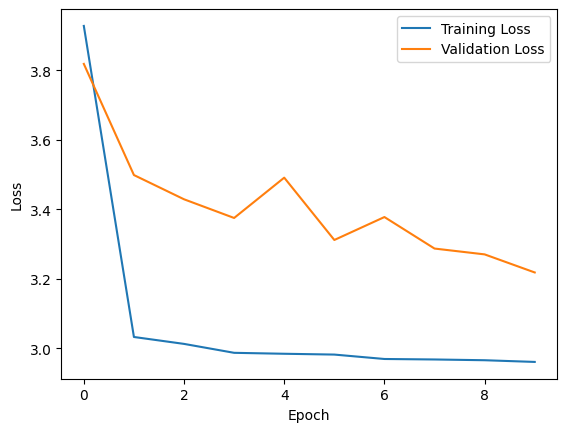

In [8]:
# Visualize the losses
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
#model = TransformerVAE(input_dim, model_dim, num_heads, num_layers, output_dim, latent_dim).to(device)
with torch.no_grad():
    for batch in test_loader:
        src = batch[0][:, :].to(device)
        
        # Initialize gen_seq with the same batch size as src
        gen_seq = torch.tensor([[3]] * src.size(0)).to(device)
        
        for i in range(1, src.size(1)):
            masked_src = src[:, :i]
            tgt = src[:, i]
            if tgt.eq(0).all():
                continue
            
            output_val, mu, logvar = model(src, gen_seq)
            next_token = torch.argmax(output_val, dim=-1)
            if next_token.ndim == 1:
                next_token = next_token.unsqueeze(1)
            gen_seq = torch.cat([gen_seq, next_token[:, -1].unsqueeze(1)], dim=-1)

        print("Generated Sequence:", gen_seq[0])
        print("Actual Sequence:", src[0])


Generated Sequence: tensor([3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       device='cuda:0')
Actual Sequence: tensor([ 3, 23, 11,  7, 13,  4, 21, 21,  4,  6, 10,  9, 14,  8, 20, 12, 23, 15,
        19, 15, 11,  6, 20, 11, 18, 21, 10,  7, 14, 21, 15, 20, 21,  6,  9,  8,
         8, 18, 19, 14, 15, 21,  6,  4, 19, 11,  4, 15, 11,  7, 21, 22, 19, 12,
        20, 11, 20, 19,  8,  9,  7, 22, 18,  7, 18,  6, 11, 11, 16, 18,  2,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
